# Plots

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tqdm 
import warnings

warnings.simplefilter(action="ignore", category=tqdm.TqdmExperimentalWarning)
warnings.simplefilter(action="ignore", category=pd.core.common.SettingWithCopyWarning)

from tqdm.autonotebook import tqdm

%matplotlib notebook
np.set_printoptions(precision=4, linewidth=500, threshold=500, suppress=True)

In [2]:
from geo.california import California
from geo.monitors import Monitors
from geo.utils import get_transform
from geo.distance import Distance

from model.laplacian import Laplacian

In [5]:
from scipy.spatial.distance import pdist, squareform
from scipy.sparse.csgraph import minimum_spanning_tree

from scipy.sparse import csr_matrix
from scipy.sparse.linalg import eigsh

In [3]:
laplacian = Laplacian()

In [4]:
cali = laplacian.distance.cali

In [5]:
lam, U = np.linalg.eigh(laplacian.L)

<IPython.core.display.Javascript object>


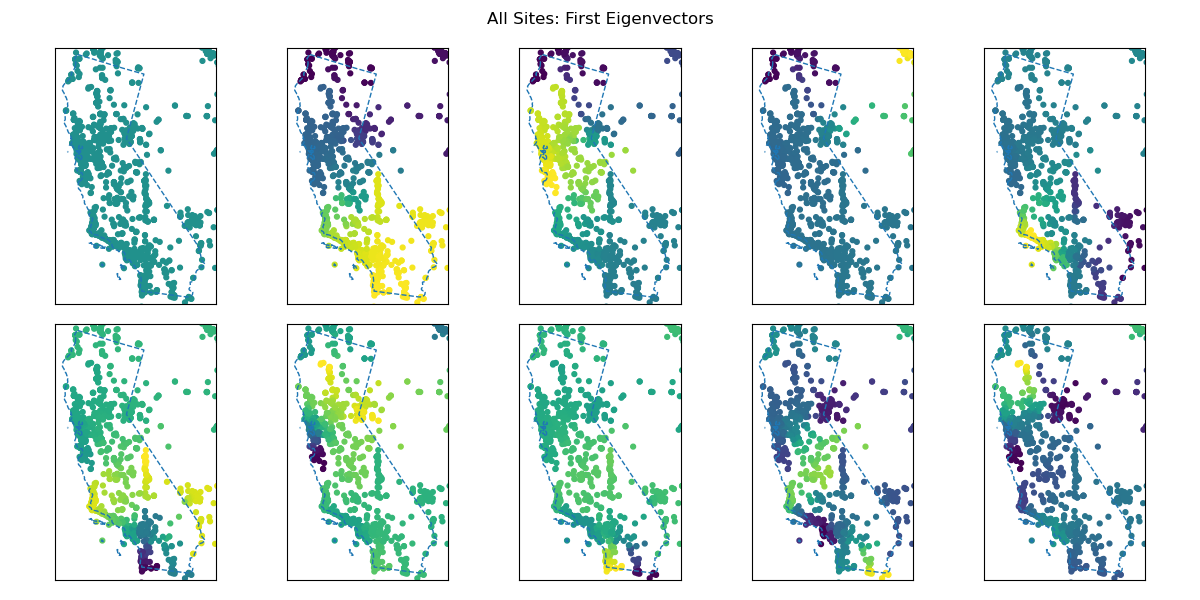

In [6]:
sites = Monitors().process()

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(12, 6))
fig.suptitle('All Sites: First Eigenvectors')

for i, ax in enumerate(axes.flatten()):
    
    cali.plot_outline(ax, dict(color='tab:blue', ls='--', lw=1))
    ax.scatter(sites['x'], sites['y'], s=12, marker='o', alpha=1, c=U[:, i], vmin=U[:, i].min() - 1e-5, vmax=U[:, i].max() + 1e-5)
    
plt.tight_layout()
plt.subplots_adjust(top=0.92)

<IPython.core.display.Javascript object>


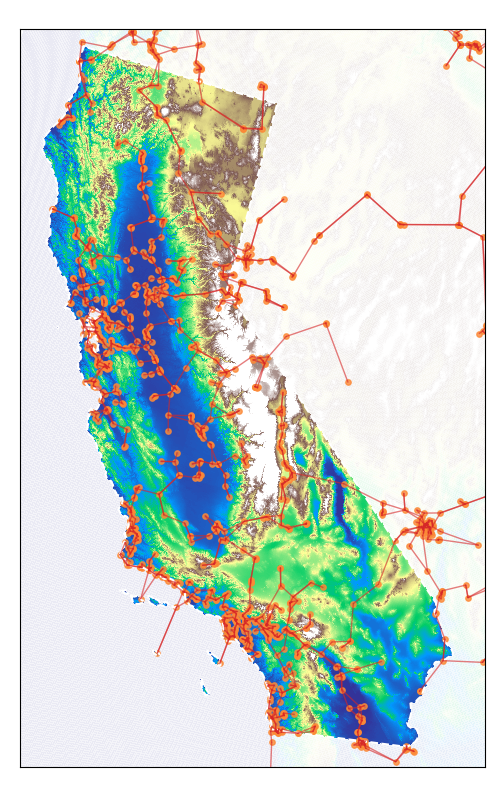

In [8]:
ax = cali.plot_elevation(gridlines=False, outline={'lw': 1.5, 'color': 'white', 'ls': '--'}, back_alpha=0.05)

x, y = sites['x'].values, sites['y'].values


scat = ax.scatter(sites['x'], sites['y'], s=15, marker='o', alpha=0.8, c='#fc8937')

for edge in laplacian.edges:
    plt.plot([x[edge[0]], x[edge[1]]], [y[edge[0]], y[edge[1]]], lw=1, color='tab:red', alpha=0.6, solid_capstyle='round')
    
plt.tight_layout()

# plt.savefig('cali-elev-map.jpg', dpi=450)

<IPython.core.display.Javascript object>


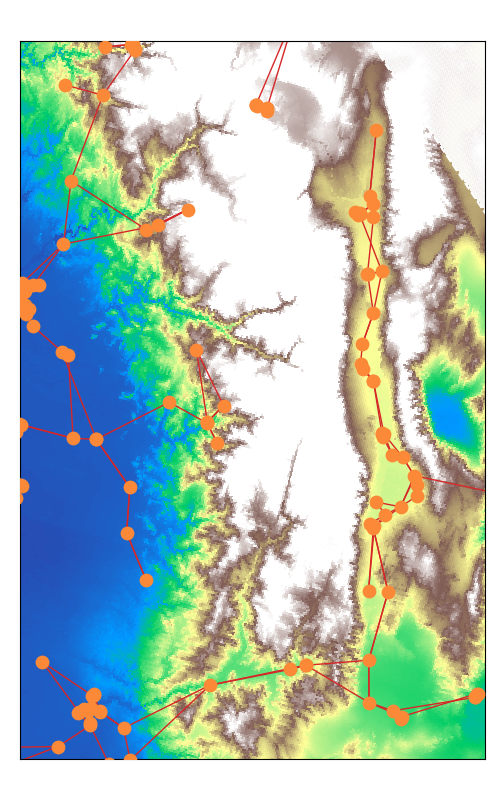

In [9]:

ax = cali.plot_elevation(gridlines=False, outline={'lw': 1.5, 'color': 'white', 'ls': '--'}, back_alpha=0.05)




for edge in laplacian.edges:
    plt.plot([x[edge[0]], x[edge[1]]], [y[edge[0]], y[edge[1]]], lw=1, color='tab:red', alpha=1, solid_capstyle='round')
    
scat = ax.scatter(sites['x'], sites['y'], s=80, marker='o', alpha=1, c='#fc8937', zorder=np.inf)

    
# scat = ax.scatter(sites['x'], sites['y'], s=5, marker='o', alpha=0.8, c='#fc8937', zorder=np.inf)

ax.set_xlim(-2.09e6, -1.904e6)
ax.set_ylim(-157000, 130000)

plt.tight_layout()


# plt.savefig('cali-elev-map-zoomed.jpg', dpi=450)